In [15]:
!pwd
import gzip
import shutil

/home/ubuntu/MIT/Project/code


In [3]:
import requests

def download_emdb_map(emdb_id, save_path):
    """
    Download an EMDB density map file using the EMDB REST API.

    Parameters:
    - emdb_id: The EMDB ID (e.g., 'EMD-xxxx').
    - save_path: Full path to save the downloaded file (including filename and extension).
    """
    # Replace {id} with the actual EMDB ID
    url = f'https://www.ebi.ac.uk/emdb/api/entry/map/{emdb_id}'
    
    # Send a GET request to the EMDB API server
    response = requests.get(url, stream=True)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Open the save_path as a file and write the content of the response to it
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"File downloaded successfully: {save_path}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")

# Example usage
#emdb_id = 'EMD-3771'  # Replace with your actual EMDB ID
#save_path = f'{emdb_id}.map.gz'  # The downloaded file will be saved with this name
#download_emdb_map(emdb_id, save_path)


In [4]:
!pwd

/home/ubuntu/MIT/Project/code


In [5]:
import requests
import os

def download_emdb_maps(emdb_ids, save_dir):
    for emdb_id in emdb_ids:
        file_name = f"emd_{emdb_id}.map.gz"
        url = f"https://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-{emdb_id}/map/{file_name}"
        save_path = os.path.join(save_dir, file_name)

        print(f"Downloading {file_name}...")
        print(url)
        response = requests.get(url, stream=True, timeout=60)  # Timeout in seconds
        
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                print("Opening file")
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Saved to {save_path}")
        else:
            print(f"Failed to download {file_name}. Status code: {response.status_code}")

# Example usage:
#emdb_ids = ['9375']  # Replace this with your list of EMDB IDs
#save_dir = './'  # Specify your directory to save maps

#download_emdb_maps(emdb_ids, save_dir)


In [22]:
import gzip
import shutil

input_path = 'emd_9375.map.gz'  # Update with the actual path to the downloaded file
output_path = './9375.map'  # Path where you want to save the decompressed file

# Decompress the file
with gzip.open(input_path, 'rb') as f_in:
    with open(output_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def plot_slices(volume):
    # Plot middle slices from each axis
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(volume[volume.shape[0] // 2], cmap="gray")
    axes[1].imshow(volume[:, volume.shape[1] // 2, :], cmap="gray")
    axes[2].imshow(volume[:, :, volume.shape[2] // 2], cmap="gray")
    plt.show()

# Assuming 'volume' is a 3D numpy array representing the decompressed map
# plot_slices(volume)


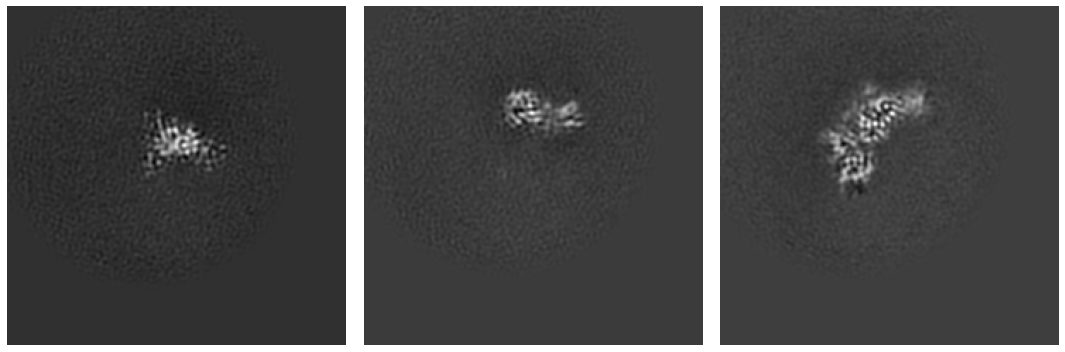

In [53]:
import mrcfile

with mrcfile.open(output_path, permissive=True) as mrc:
    volume = mrc.data
    plot_slices(volume)

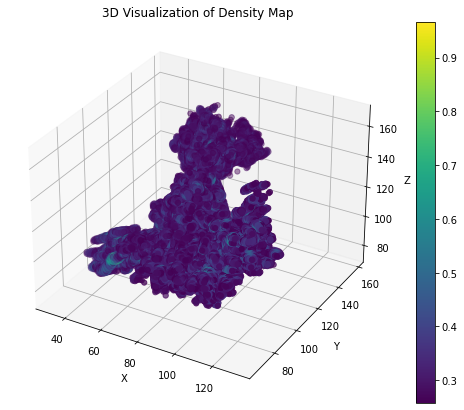

In [54]:
import numpy as np
import mrcfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the volume from the MRC file
#with mrcfile.open(output_path, permissive=True) as mrc:
    # Perform an inverse Fourier transform if the data is in Fourier space
    # volume = np.fft.ifftn(mrc.data).real
    # volume = np.abs(np.fft.ifftn(mrc.data))

# Apply a threshold to the volume to visualize regions with higher density
threshold = np.mean(volume) + 10.0 * np.std(volume)
mask = volume > threshold

# Get the indices of points above the threshold
x, y, z = np.indices(volume.shape)
x = x[mask]
y = y[mask]
z = z[mask]
values = volume[mask]

# Create a 3D scatter plot of the points above the threshold
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: more dense points are larger and more opaque
p = ax.scatter(x, y, z, c=values, cmap='viridis', s=100*values/max(values))
fig.colorbar(p)

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of Density Map')

# Show the plot
plt.show()


In [51]:
import numpy as np
import mrcfile
from scipy.ndimage import gaussian_filter

def load_map_and_standardize(filepath, smoothing_sigma=1):
    with mrcfile.open(filepath, permissive=True) as mrc:
        volume = mrc.data.astype(np.float32)
        
    # Normalize the volume if desired
    # volume = (volume - np.mean(volume)) / np.std(volume)
    
    # Apply Gaussian smoothing to reduce noise
    if smoothing_sigma:
        volume = gaussian_filter(volume, sigma=smoothing_sigma)
    
    # Choose a threshold, e.g., 1 std dev above the mean
    threshold = np.mean(volume) + np.std(volume)
    
    return volume, threshold

# Now you can loop over your map files, call this function for each,
# and use the returned standardized threshold for isosurface generation.

In [61]:
import numpy as np

# Let's assume you have a 3D numpy array called 'voxel_data'
# voxel_data = np.load('path_to_your_voxel_data.npy')

# Compute the FFT of the 3D voxel data
fourier_transformed = np.fft.fftn(volume)

# The result is a complex array where the magnitude gives you the amplitude of the frequency components
# and the phase gives you the phase offset

# Often, you'll want to shift the zero-frequency component to the center of the spectrum
fourier_transformed_shifted = np.fft.fftshift(fourier_transformed)

# You might be interested in the magnitude spectrum, for visualization or further processing
magnitude_spectrum = np.abs(fourier_transformed_shifted)

# Save or process your Fourier-transformed data
# np.save('path_to_save_fourier_data.npy', magnitude_spectrum)


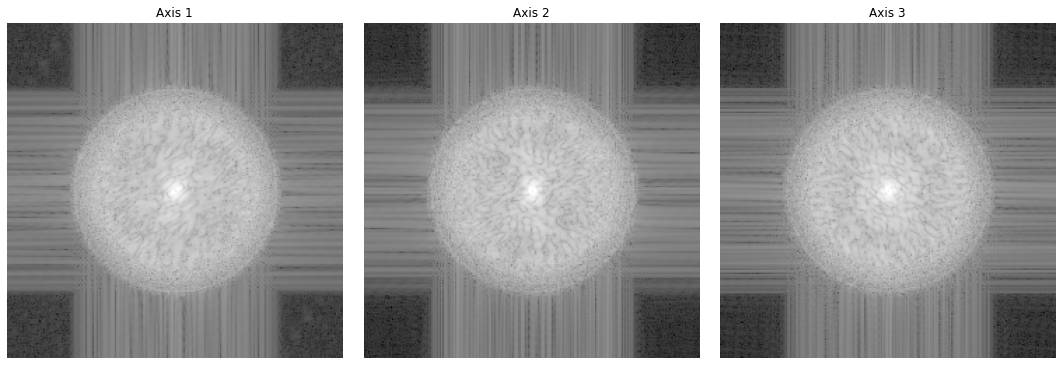

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Let's assume 'fourier_transformed_shifted' is your Fourier-transformed 3D numpy array
# fourier_transformed_shifted = np.fft.fftn(voxel_data)
# fourier_transformed_shifted = np.fft.fftshift(fourier_transformed_shifted)
magnitude_spectrum = np.abs(fourier_transformed_shifted)

# Define a function to plot middle slices from each axis of the Fourier magnitude
def plot_fourier_slices(magnitude):
    # Middle slices of each axis
    slices = [magnitude[magnitude.shape[0] // 2],
              magnitude[:, magnitude.shape[1] // 2],
              magnitude[:, :, magnitude.shape[2] // 2]]
    
    # Set up the subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot each slice
    for i, slice in enumerate(slices):
        axes[i].imshow(np.log(slice + 1e-5), cmap='gray')  # Log scale for better visibility
        axes[i].set_title(f'Axis {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize middle slices of the Fourier magnitude
plot_fourier_slices(magnitude_spectrum)


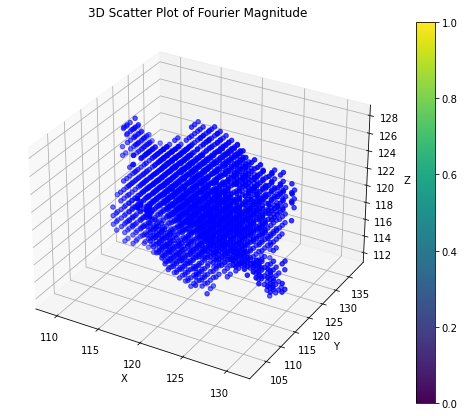

In [66]:
from mpl_toolkits.mplot3d import Axes3D

# Threshold the magnitude to get significant frequencies
threshold = magnitude_spectrum.mean() + 15 * magnitude_spectrum.std()
indices = np.where(magnitude_spectrum > threshold)

# Create a 3D scatter plot for significant frequencies
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
q =ax.scatter(indices[0], indices[1], indices[2], c='b', marker='o')
fig.colorbar(q)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Fourier Magnitude')
plt.show()


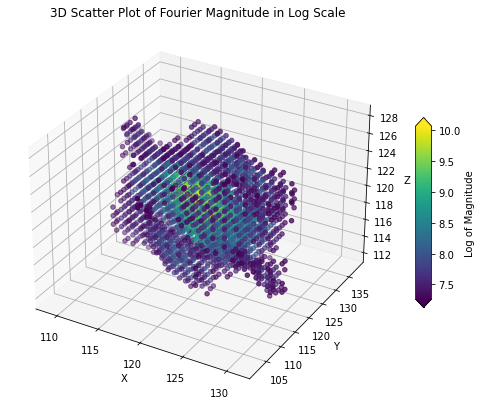

In [113]:
from mpl_toolkits.mplot3d import Axes3D

# Assume 'magnitude_spectrum' is the magnitude of the Fourier transform
# Apply a threshold to get the significant magnitudes for visualization
threshold = magnitude_spectrum.mean() + 15 * magnitude_spectrum.std()
indices = np.where(magnitude_spectrum > threshold)

# The actual magnitudes corresponding to the indices above the threshold
magnitudes_above_threshold = magnitude_spectrum[indices]

# Create the scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Use the log of the magnitudes as the color mapping
# Adding a small constant inside the log to avoid taking the logarithm of zero
log_magnitudes = np.log(magnitudes_above_threshold + 1e-5)

# Create a scatter plot, using log_magnitudes for coloring
scatter_plot = ax.scatter(indices[0], indices[1], indices[2], c=log_magnitudes, cmap='viridis', marker='o')

# Create a colorbar with a logarithmic scale
cbar = fig.colorbar(scatter_plot, extend='both', shrink=0.5, aspect=12)
cbar.set_label('Log of Magnitude')

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Fourier Magnitude in Log Scale')

plt.show()


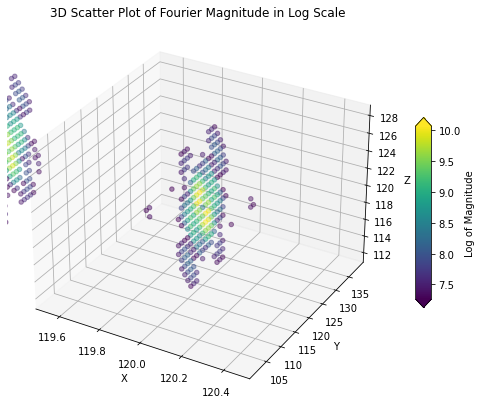

In [114]:
from mpl_toolkits.mplot3d import Axes3D

# Assume 'magnitude_spectrum' is the magnitude of the Fourier transform
# Apply a threshold to get the significant magnitudes for visualization
threshold = magnitude_spectrum.mean() + 15 * magnitude_spectrum.std()
indices = np.where(magnitude_spectrum > threshold)

# The actual magnitudes corresponding to the indices above the threshold
magnitudes_above_threshold = magnitude_spectrum[indices]

# Create the scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Use the log of the magnitudes as the color mapping
# Adding a small constant inside the log to avoid taking the logarithm of zero
log_magnitudes = np.log(magnitudes_above_threshold + 1e-5)

# Create a scatter plot, using log_magnitudes for coloring
scatter_plot = ax.scatter(indices[0], indices[1], indices[2], c=log_magnitudes, cmap='viridis', marker='o')

# Create a colorbar with a logarithmic scale
cbar = fig.colorbar(scatter_plot, extend='both', shrink=0.5, aspect=12)
cbar.set_label('Log of Magnitude')

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Fourier Magnitude in Log Scale')

plt.xlim(119.5, 120.5)
plt.show()


In [47]:
## import numpy as np
import pandas as pd

# Example usage:
#emdb_ids = ['9375']  # Replace this with your list of EMDB IDs
#save_dir = '../data/emdb_files/'  # Specify your directory to save maps

#download_emdb_maps(emdb_ids, save_dir)

#input_path = 'emd_9375.map.gz'  # Update with the actual path to the downloaded file
#output_path = './9375.map'  # Path where you want to save the decompressed file

# Decompress the file
#with gzip.open(input_path, 'rb') as f_in:
#    with open(output_path, 'wb') as f_out:
#        shutil.copyfileobj(f_in, f_out)

file_path = '../data/DATA.xlsx'
save_dir = '../data/emdb_files/' 

# Read the Excel file
df = pd.read_excel(file_path)
df = df.drop(df.index[0])
column_names = ['PDB','EMDB','Resolution']
df.columns = column_names
print(df.head())
print(type(df['EMDB'][1]))

'''
download_emdb_maps(df['EMDB'], save_dir)
'''

for x in df['EMDB'][159:]:
    emdb_id = x
    print(emdb_id)
    
    input_path = f'{save_dir}emd_{emdb_id}.map.gz' 
    output_path = f'{save_dir}{emdb_id}.map'  
    
    with gzip.open(input_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)


    PDB  EMDB Resolution
1  5OAC  3771          4
2  6BO4  7118          4
3  6BVF  7294          4
4  6CES  7464          4
5  6HRB  0258          4
<class 'str'>
10387
21985
22144
11340
12053
30323
9535
20047
20725
21173
30041
6034
5917
3776
0264
9664
9577
10188
11338
22630
22216
6535
2788
3602
6862
10210
22589
3439
6875
11815
30463
8073
4061
8665
7125
20017
22326
22754
5577
10135
22423
22233
23923
8954
30349
7055
7322
7332
3856
9317
21121
3491
9537
4342
4876
12054
4707
8436
8711
4400
20924
1886
3056
3885
30341
8470
0026
0608
10615
21611
5465
1874
8230
5410
3636
7065
22647
5245
6927
5100
3761
6284
3436
8097
20122
3340
8187
7461
2511
21692
2685
20613
3283
8673
9949
8685
3186


In [39]:
df[df['EMDB'] == '4659']

,PDB,EMDB,Resolution
158,6QWJ,4659,4.5


In [46]:
df['EMDB'][159:]

160    10387
161    21985
162    22144
163    11340
164    12053
       ...  
252     3283
253     8673
254     9949
255     8685
256     3186
Name: EMDB, Length: 97, dtype: object

In [70]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


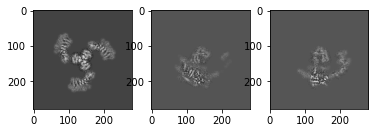

Volume shape: (280, 280, 280) /nVolume type: <class 'numpy.ndarray'>


In [107]:
import mrcfile

volume = []
with mrcfile.open('../data/emdb_files/0946.map', permissive=True) as mrc:
    volume = mrc.data
    plot_slices(volume)

print(f'Volume shape: {volume.shape} /nVolume type: {type(volume)}')


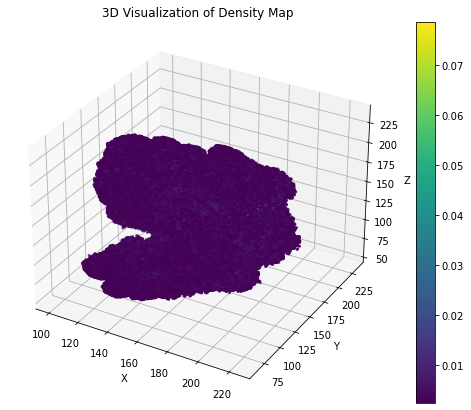

In [108]:
import numpy as np
import mrcfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the volume from the MRC file
#with mrcfile.open(output_path, permissive=True) as mrc:
    # Perform an inverse Fourier transform if the data is in Fourier space
    # volume = np.fft.ifftn(mrc.data).real
    # volume = np.abs(np.fft.ifftn(mrc.data))

# Apply a threshold to the volume to visualize regions with higher density
threshold = np.mean(volume) + 1.0 * np.std(volume)
mask = volume > threshold

# Get the indices of points above the threshold
x, y, z = np.indices(volume.shape)
x = x[mask]
y = y[mask]
z = z[mask]
values = volume[mask]

# Create a 3D scatter plot of the points above the threshold
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: more dense points are larger and more opaque
p = ax.scatter(x, y, z, c=values, cmap='viridis', s=100*values/max(values))
fig.colorbar(p)

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of Density Map')

# Show the plot
plt.show()
